In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import datetime as dt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt

from sklearn.linear_model import QuantileRegressor
import sklearn

# Load in the dataset

In [3]:
# Load this to train regression!

daily_ds = xr.open_dataset('/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/ERA5_MIDWEST_heat_metrics_1940-2024_2025-04-15_daily_max.nc')
daily_ds = daily_ds.sortby('lat', ascending=True) # fix the lat coord to be ascending (it's unorganized for some reason)
daily_ds

<xarray.Dataset> Size: 473MB
Dimensions:  (lon: 95, lat: 53, date: 7820)
Coordinates:
  * lon      (lon) float32 380B 256.2 256.5 256.8 257.0 ... 279.2 279.5 279.8
  * lat      (lat) float32 212B 36.25 36.5 36.75 37.0 ... 48.5 48.75 49.0 49.25
  * date     (date) datetime64[ns] 63kB 1940-06-01 1940-06-02 ... 2024-08-31
Data variables:
    t2m      (date, lat, lon) float32 157MB ...
    wb       (date, lat, lon) float32 157MB ...
    hi       (date, lat, lon) float32 157MB ...
Attributes:
    title:    Combined Maximum Temperature Data
    summary:  ERA5 Dataset containing maximum daily of temperature, wet-bulb ...

In [2]:
icn_ds = xr.open_dataset('ICN/ICN_heat_metrics_1989-2024_2025-04-17_daily_max.nc')
icn_ds

<xarray.Dataset> Size: 265kB
Dimensions:  (station: 3, date: 3312)
Coordinates:
  * station  (station) <U11 132B 'Champaign' 'Springfield' 'Carbondale'
  * date     (date) datetime64[ns] 26kB 1989-06-01 1989-06-02 ... 2024-08-31
Data variables:
    t2m      (station, date) float64 79kB ...
    wb       (station, date) float64 79kB ...
    hi       (station, date) float64 79kB ...
Attributes:
    title:    Combined Maximum Temperature Data
    summary:  ICN Dataset containing maximum daily of temperature, wet-bulb t...

# Train Regression

In [3]:
def quantile_regression(y, X, quantile):
    """
    Use sklearn's QuantileRegressor to
    Returns an array with [slope, intercept].
    
    Parameters
    ----------
    y : array, shape (time,) values at one grid point.
    X : array, should be the date values
    """
    
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    qr.fit(X, y)
    return np.array([qr.coef_[0], qr.intercept_])

# Selecting data to perform
ds = daily_ds
# ds = daily_ds.sel(date=(slice('1989-01-01', '2024-12-31'))) # for ICN comparison
ds = ds.sel(lat=slice(36, 43.5)).sel(lon=slice(267.2,274)) # Illinois only

quantiles = [int('95'), int('50')]
variables = ['t2m', 'wb', 'hi']

In [4]:
import os
#Processing
X = ds.date.values[:, np.newaxis].astype('datetime64[D]').astype('int64')

for variable in variables:
    for quantile in quantiles:
        # change the file outputs here
        f_out = f'/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/{quantile}/{variable}_overall_{quantile}qr.nc'
        if not os.path.exists(f_out):
            result = xr.apply_ufunc(
                quantile_regression,
                ds[variable],  # the data variable to process
                input_core_dims=[["date"]],  
                kwargs={'X': X, 'quantile': (quantile/100)},  
                vectorize=True,
                dask='parallelized', 
                output_core_dims=[["params"]],
                output_dtypes=[float]
            )
            
            slope = result.sel(params=0)
            intercept = result.sel(params=1)
            
            slope.attrs['description'] = f'The beta values. The trend of the {quantile}th linear regression'
            intercept.attrs['description'] = f'The alpha values. The baseline {quantile}qr temperature'
            
            save_ds = xr.Dataset({
                'slope': slope,
                'intercept': intercept
            }, attrs={
                'title': f'{quantile}th QuantileRegressor of {variable}',
                'summary': f'Dataset the slope and intersect of {quantile}th QuantileRegressor of {variable}.'}
            )
            save_ds.to_netcdf(f_out)
            print(f"saved to {f_out}")
        else:
            print(f"passing {f_out}")

passing /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/95/t2m_overall_95qr.nc
passing /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/50/t2m_overall_50qr.nc
passing /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/95/wb_overall_95qr.nc
passing /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/50/wb_overall_50qr.nc
saved to /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/95/hi_overall_95qr.nc
saved to /data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/50/hi_overall_50qr.nc


# Plot the regression

## Map form: Plot the regression as map gridpoints

0 = deg/day 1 = deg/decade, 2 = deg/64 years (1940-2024)


Enter your selection:  2


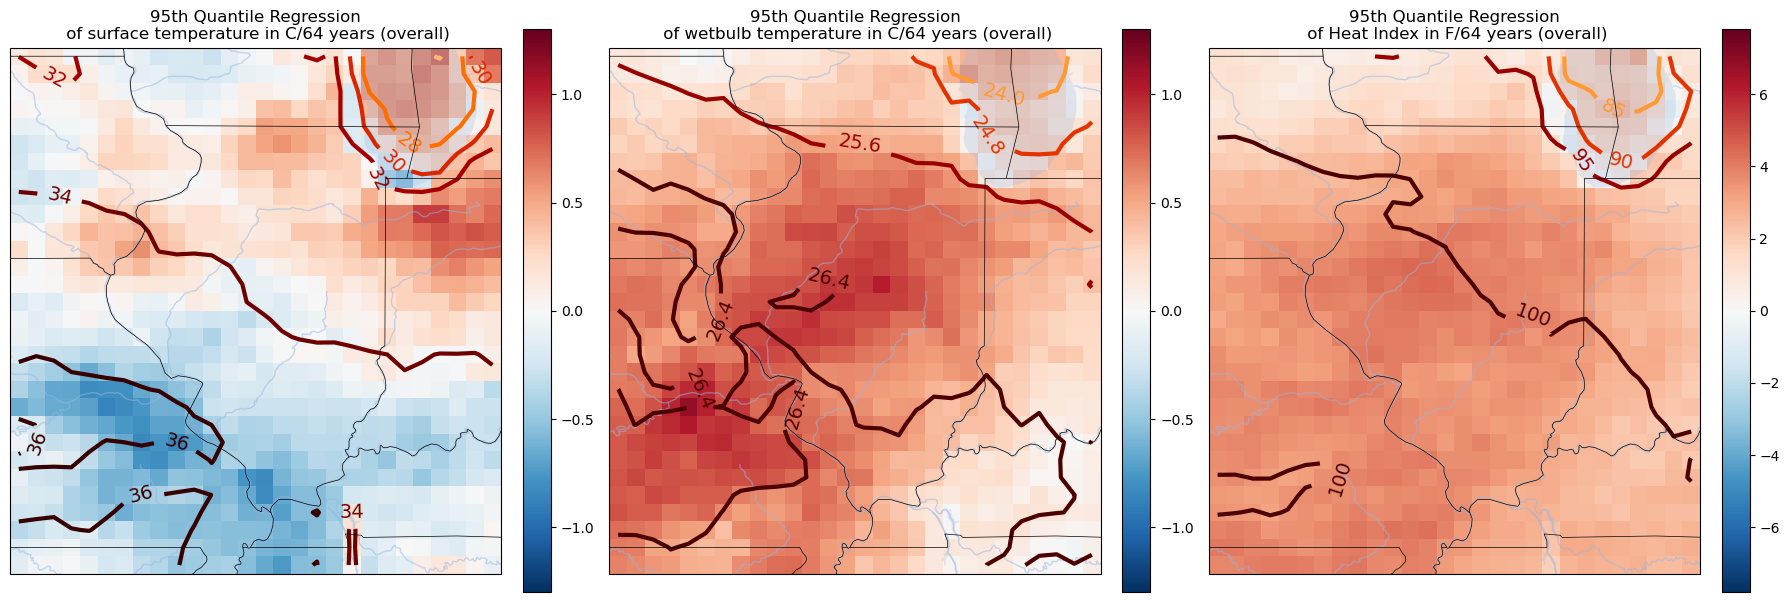

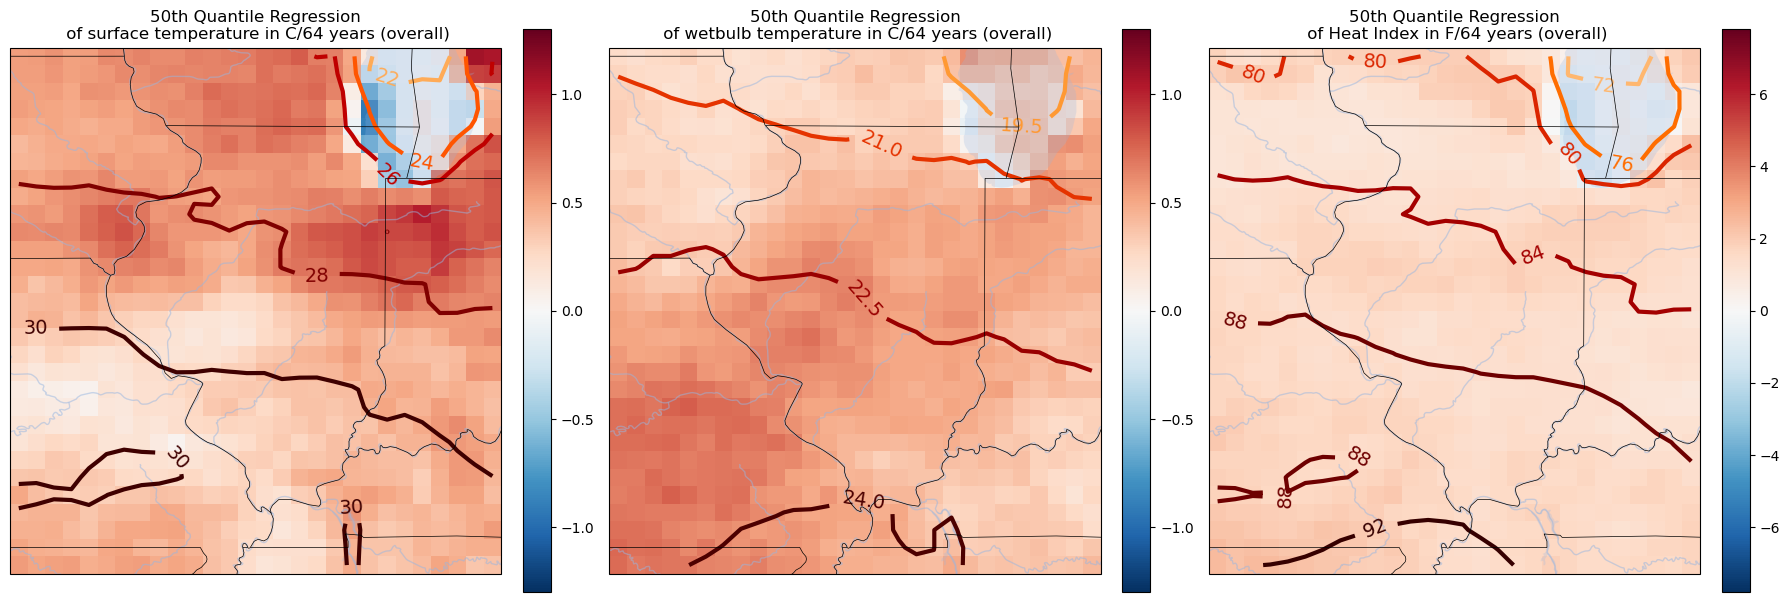

In [5]:
# Helper function to add common map features to an axis
def add_map_features(ax):
    ax.add_feature(cfeature.LAKES, alpha=0.25)  # Add lakes
    ax.add_feature(cfeature.RIVERS, alpha=0.5)   # Add rivers
    ax.add_feature(cfeature.BORDERS, linestyle=":")  # Add borders
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  
        name='admin_1_states_provinces_lines',
        scale='50m', 
        linewidth=0.5, 
        facecolor='none'
    )
    ax.add_feature(states_provinces, edgecolor='black', zorder=10)

# ==========================================================================
# ==========================================================================

root_dir = '/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr'
quantiles = ['95','50']

print("0 = deg/day 1 = deg/decade, 2 = deg/64 years (1940-2024)") 
selection = input("Enter your selection: ")
selection = int(selection)

for q_ind, quantile in enumerate(quantiles):
    t2m_qr = xr.open_dataset(f'{root_dir}/{quantile}/t2m_overall_{quantile}qr.nc')
    wb_qr = xr.open_dataset(f'{root_dir}/{quantile}/wb_overall_{quantile}qr.nc')
    hi_qr = xr.open_dataset(f'{root_dir}/{quantile}/hi_overall_{quantile}qr.nc')

    if selection == 1:
        t2m_slope = t2m_qr.slope * ( 365.25 * 10 )
        wb_slope = wb_qr.slope * ( 365.25 * 10 )
        hi_slope = hi_qr.slope * ( 365.25 * 10 )
        
        unit = "/decade"
        s_min = -0.20
        s_max = 0.20
    elif selection == 2:
        t2m_slope = t2m_qr.slope * ( 365.25 * 64 )
        wb_slope = wb_qr.slope * ( 365.25 * 64 )
        hi_slope = hi_qr.slope * ( 365.25 * 64 )

        unit = "/64 years (overall)"
        s_min = -0.20*6.5
        s_max = 0.20*6.5
    else:
        t2m_slope = t2m_qr.slope
        wb_slope = wb_qr.slope
        hi_slope = hi_qr.slope

        unit = "/day"
        s_min = -0.00005
        s_max = 0.00005

    # Create a single figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 7), dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    # Add features to both axes
    add_map_features(ax1)
    add_map_features(ax2)
    add_map_features(ax3)
    
    # Temperature
    im1 = t2m_slope.plot(ax=ax1, add_colorbar=False, vmin=s_min, vmax=s_max, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = t2m_qr.intercept.plot.contour(ax=ax1, cmap='gist_heat_r', linewidths=3)
    ax1.clabel(CS, fontsize=14)
    
    ax1.set_title(f"{quantile}th Quantile Regression\n of surface temperature in C{unit}")
    
    # Wetbulb
    im1 = wb_slope.plot(ax=ax2, add_colorbar=False, vmin=s_min, vmax=s_max, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax2, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = wb_qr.intercept.plot.contour(ax=ax2, cmap='gist_heat_r', linewidths=3)
    ax2.clabel(CS, fontsize=14)
    
    ax2.set_title(f"{quantile}th Quantile Regression\n of wetbulb temperature in C{unit}")

    # Heat Index
    im1 = hi_slope.plot(ax=ax3, add_colorbar=False, vmin=s_min*6, vmax=s_max*6, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax3, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = hi_qr.intercept.plot.contour(ax=ax3, cmap='gist_heat_r', linewidths=3)
    ax3.clabel(CS, fontsize=14)
    
    ax3.set_title(f"{quantile}th Quantile Regression\n of Heat Index in F{unit}")
    
    plt.tight_layout()
    plt.show()

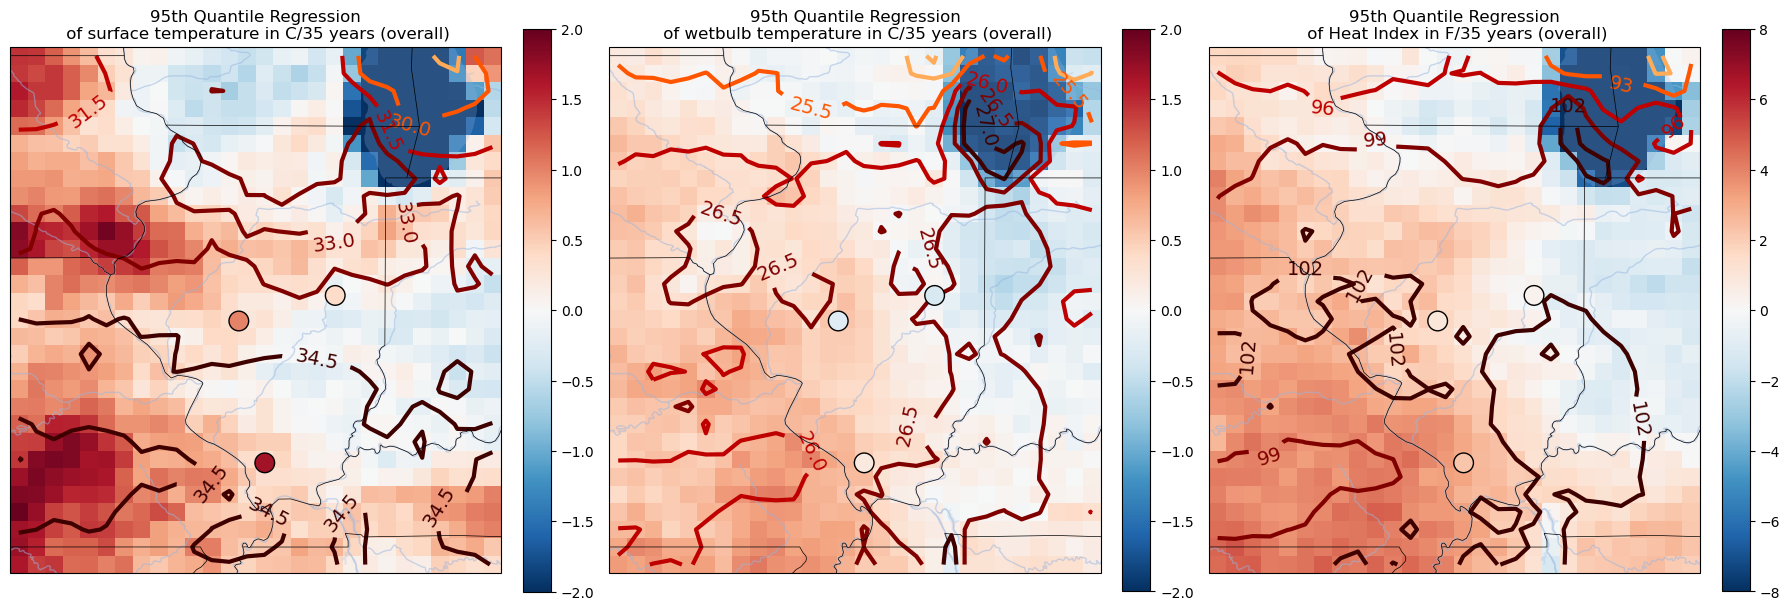

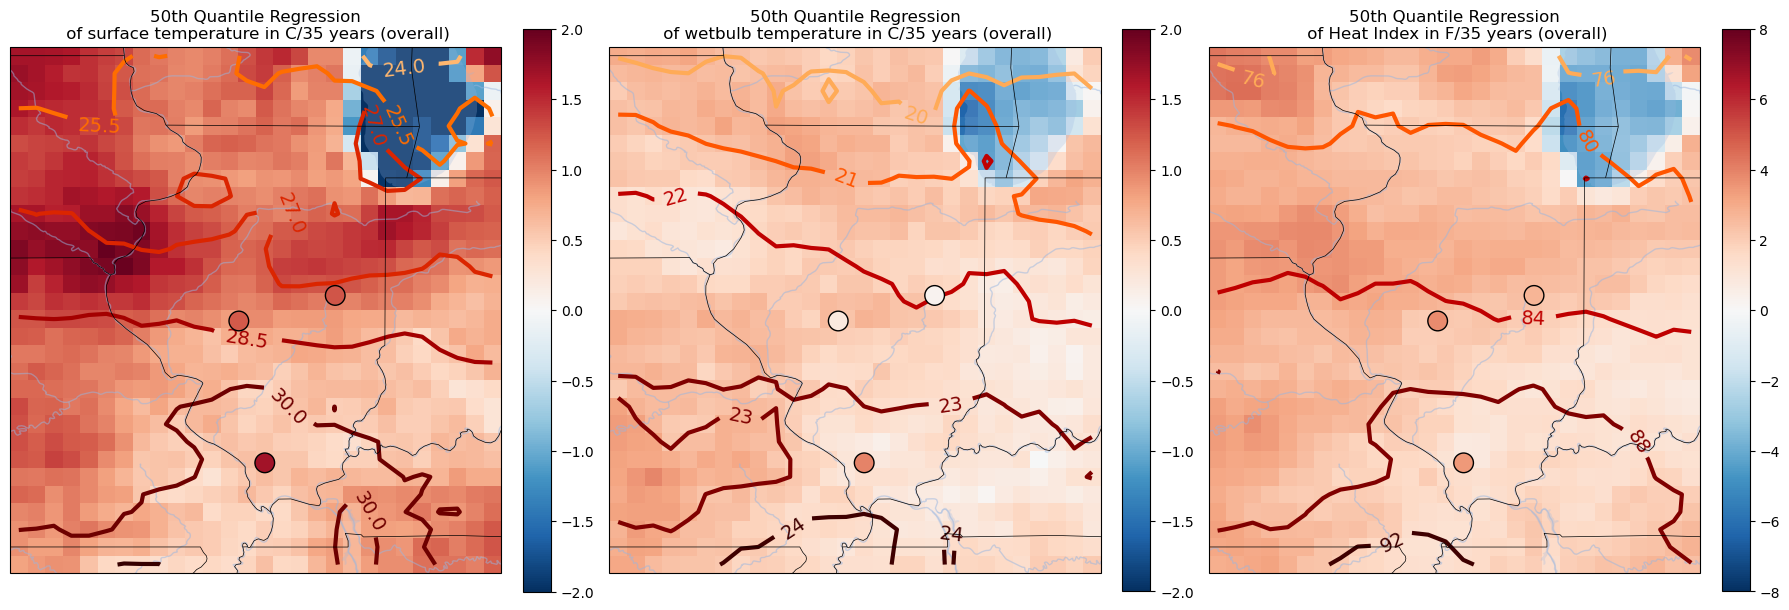

In [2]:
# Helper function to add common map features to an axis
def add_map_features(ax):
    ax.add_feature(cfeature.LAKES, alpha=0.25)  # Add lakes
    ax.add_feature(cfeature.RIVERS, alpha=0.5)   # Add rivers
    ax.add_feature(cfeature.BORDERS, linestyle=":")  # Add borders
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  
        name='admin_1_states_provinces_lines',
        scale='50m', 
        linewidth=0.5, 
        facecolor='none'
    )
    ax.add_feature(states_provinces, edgecolor='black', zorder=10)

def assign_coordinates(ds):
    station_locs = {
        'Champaign':   (40.085571, -88.240141),
        'Springfield': (39.721302, -89.613882),
        'Carbondale':  (37.699711, -89.244105),
    }

    stations = ds.station.values
    
    lats = [station_locs[name][0] for name in stations]
    lons = [station_locs[name][1] for name in stations]

    ds = ds.assign_coords({
        'lat': ('station', lats),
        'lon': ('station', lons),
    })

    return ds;
# ==========================================================================
# ==========================================================================

root_dir = '/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/icn'
icn_dir = '/data/cristi/a/kchoo3/projects/cdds-heat-metrics/ICN/qr/illinois'
quantiles = ['95','50']

# print("0 = deg/day 1 = deg/decade, 2 = deg/64 years (1940-2024)") 
# selection = input("Enter your selection: ")
# selection = int(selection)

for q_ind, quantile in enumerate(quantiles):
    t2m_qr = xr.open_dataset(f'{root_dir}/{quantile}/t2m_overall_{quantile}qr.nc')
    wb_qr = xr.open_dataset(f'{root_dir}/{quantile}/wb_overall_{quantile}qr.nc')
    hi_qr = xr.open_dataset(f'{root_dir}/{quantile}/hi_overall_{quantile}qr.nc')

    icn_t2m_qr = xr.open_dataset(f'{icn_dir}/{quantile}/t2m_overall_{quantile}qr.nc')
    icn_wb_qr = xr.open_dataset(f'{icn_dir}/{quantile}/wb_overall_{quantile}qr.nc')
    icn_hi_qr = xr.open_dataset(f'{icn_dir}/{quantile}/hi_overall_{quantile}qr.nc')

    icn_t2m_qr = assign_coordinates(icn_t2m_qr)
    icn_wb_qr = assign_coordinates(icn_wb_qr)
    icn_hi_qr = assign_coordinates(icn_hi_qr)

    t2m_slope = t2m_qr.slope * ( 365.25 * 35 )
    wb_slope = wb_qr.slope * ( 365.25 * 35 )
    hi_slope = hi_qr.slope * ( 365.25 * 35 )

    icn_t2m_slope = icn_t2m_qr.slope * ( 365.25 * 35 )
    icn_wb_slope = icn_wb_qr.slope * ( 365.25 * 35 )
    icn_hi_slope = icn_hi_qr.slope * ( 365.25 * 35 )
    unit = "/35 years (overall)"
    s_min = -2
    s_max = 2

    # Create a single figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 7), dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    # Add features to both axes
    add_map_features(ax1)
    add_map_features(ax2)
    add_map_features(ax3)
    
    # Temperature
    im1 = t2m_slope.plot(ax=ax1, add_colorbar=False, vmin=s_min, vmax=s_max, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = t2m_qr.intercept.plot.contour(ax=ax1, cmap='gist_heat_r', linewidths=3)
    ax1.clabel(CS, fontsize=14)

    ax1.scatter(icn_t2m_qr.lon, icn_t2m_qr.lat,
                c=icn_t2m_slope, cmap='RdBu_r',
                edgecolor='k', s=200,
                transform=ccrs.PlateCarree(), zorder=20,
                vmin=s_min, vmax=s_max)
    
    ax1.set_title(f"{quantile}th Quantile Regression\n of surface temperature in C{unit}")
    
    # Wetbulb
    im1 = wb_slope.plot(ax=ax2, add_colorbar=False, vmin=s_min, vmax=s_max, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax2, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = wb_qr.intercept.plot.contour(ax=ax2, cmap='gist_heat_r', linewidths=3)
    ax2.clabel(CS, fontsize=14)

    ax2.scatter(icn_wb_qr.lon, icn_wb_qr.lat,
                c=icn_wb_slope, cmap='RdBu_r',
                edgecolor='k', s=200,
                transform=ccrs.PlateCarree(), zorder=20,
                vmin=s_min, vmax=s_max) 
    
    ax2.set_title(f"{quantile}th Quantile Regression\n of wetbulb temperature in C{unit}")

    # Heat Index
    im1 = hi_slope.plot(ax=ax3, add_colorbar=False, vmin=s_min*4, vmax=s_max*4, cmap='RdBu_r')
    cbar1 = fig.colorbar(im1, ax=ax3, orientation='vertical', fraction=0.052, pad=0.04)
    
    CS = hi_qr.intercept.plot.contour(ax=ax3, cmap='gist_heat_r', linewidths=3)
    ax3.clabel(CS, fontsize=14)

    ax3.scatter(icn_hi_qr.lon, icn_hi_qr.lat,
                c=icn_hi_slope, cmap='RdBu_r',
                edgecolor='k', s=200,
                transform=ccrs.PlateCarree(), zorder=20,
                vmin=s_min*4, vmax=s_max*4)
    
    ax3.set_title(f"{quantile}th Quantile Regression\n of Heat Index in F{unit}")
    
    plt.tight_layout()
    plt.show()

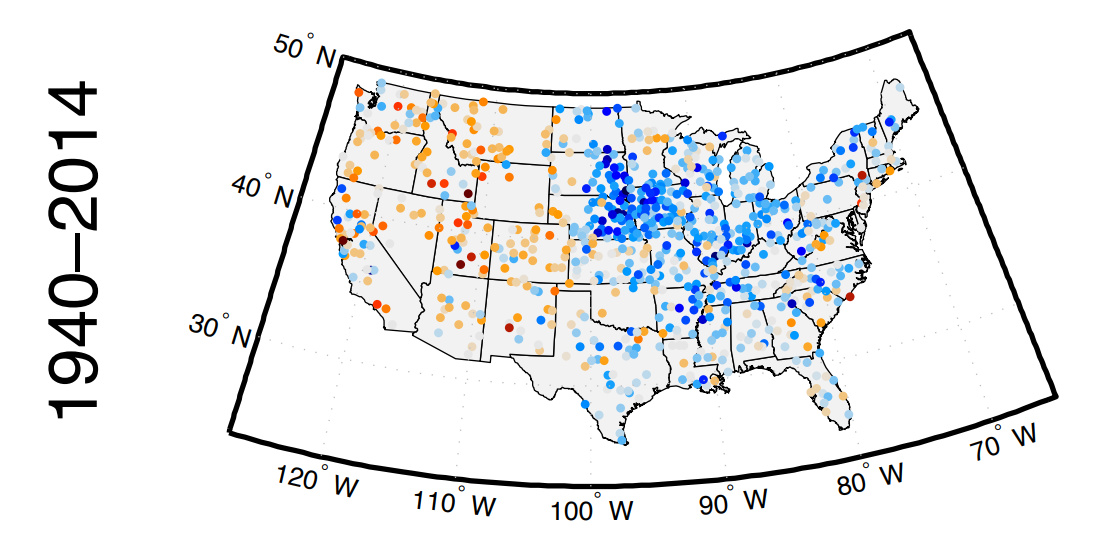

Figure above:           95th Quantile of observed surface temperature from 1940-2014, no exclusion
Data used in the paper: GHCND database
Source:                 Mueller et al. 2016


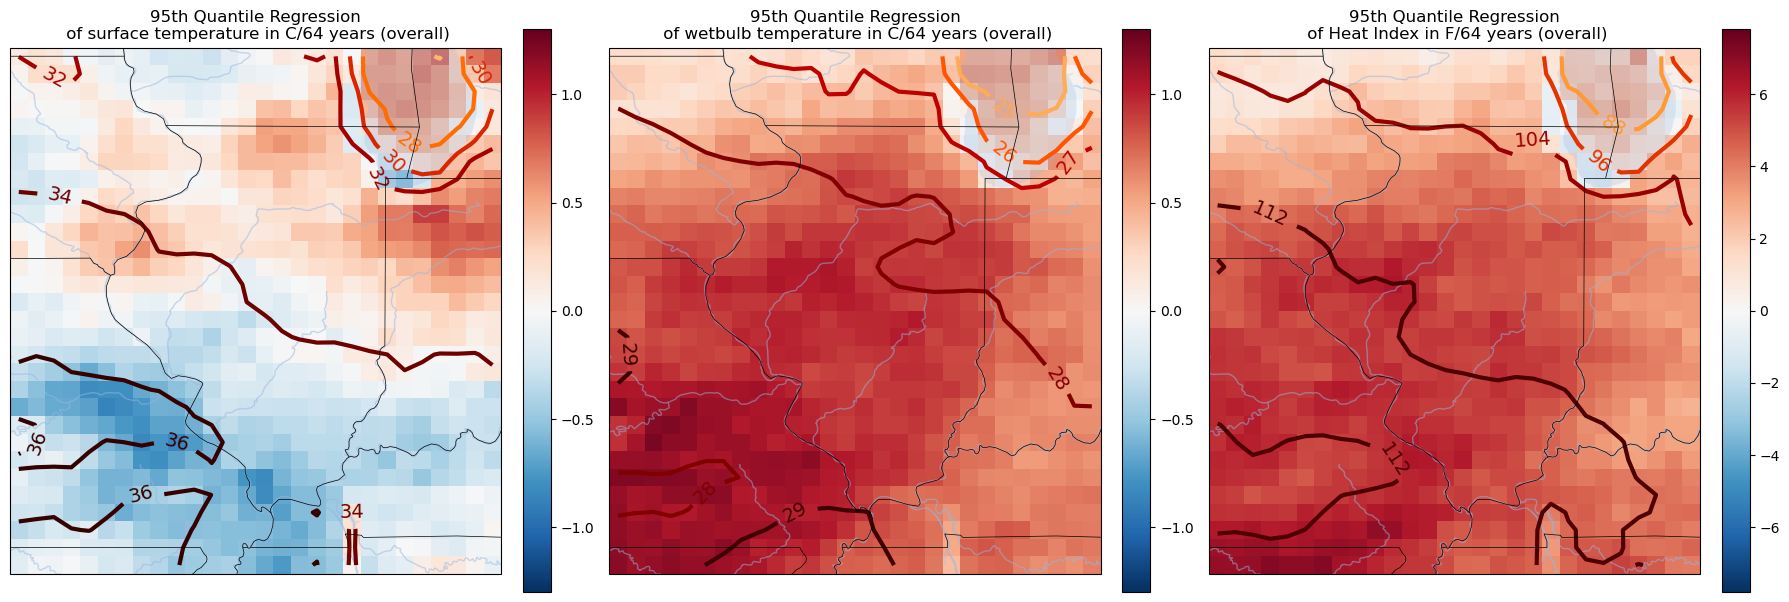

Figure above: 95th Quantile of various matric from 1940-2024, no exclusion
Data used:    ERA5 reanalysis data: analysis-ready


In [30]:
from IPython.display import Image, display
image_path = "figures/paper/mueller16_1940-2014_all.png"
display(Image(filename=image_path, width=600))
print("Figure above:           95th Quantile of observed surface temperature from 1940-2014, no exclusion")
print("Data used in the paper: GHCND database")
print("Source:                 Mueller et al. 2016")


image_path = "figures/era5_outputs/q95_overall.png"
display(Image(filename=image_path))
print("Figure above: 95th Quantile of various matric from 1940-2024, no exclusion")
print("Data used:    ERA5 reanalysis data: analysis-ready")

## ERA5 and ICN correlation

In [19]:
icn_ds['t2m'].stack(points=('station', 'date'))

<xarray.DataArray 't2m' (points: 9936)> Size: 79kB
array([28.7, 27.5, 26.3, ..., 35.8, 33.4, 29.4])
Coordinates:
    lat      (points) float64 79kB 40.09 40.09 40.09 40.09 ... 37.7 37.7 37.7
    lon      (points) float64 79kB -88.24 -88.24 -88.24 ... -89.24 -89.24 -89.24
  * points   (points) object 79kB MultiIndex
  * station  (points) <U11 437kB 'Champaign' 'Champaign' ... 'Carbondale'
  * date     (points) datetime64[ns] 79kB 1989-06-01 1989-06-02 ... 2024-08-31
Attributes:
    units:        Celsius
    description:  Temperature in Celsius

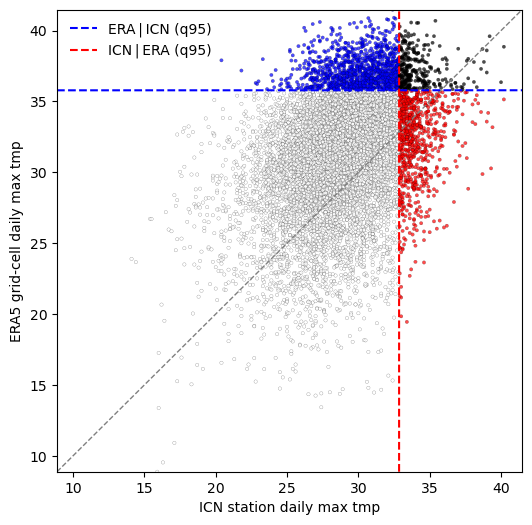

In [38]:
icn_ds = xr.open_dataset('ICN/ICN_heat_metrics_1989-2024_2025-04-17_daily_max.nc')

def assign_coordinates(ds):
    station_locs = {
        'Champaign':   (40.085571, -88.240141),
        'Springfield': (39.721302, -89.613882),
        'Carbondale':  (37.699711, -89.244105),
    }

    stations = ds.station.values
    
    lats = [station_locs[name][0] for name in stations]
    lons = [station_locs[name][1] for name in stations]

    ds = ds.assign_coords({
        'lat': ('station', lats),
        'lon': ('station', lons),
    })

    return ds;

icn_ds = assign_coordinates(icn_ds)

era5_ds = daily_ds.sel(date=(slice('1989-01-01', '2024-12-31')))

era_at_stations = era5_ds.sel(
    lat=icn_ds['lat'],
    lon=icn_ds['lon'],
    method='nearest'
)

x = icn_ds['t2m'].stack(points=('station', 'date')).values
y = era_at_stations['t2m'].stack(points=('station', 'date')).values

# keep only pairs where both numbers are finite
mask = np.isfinite(x) & np.isfinite(y)
x_clean, y_clean = x[mask], y[mask]

def quantile_regression(y, X, quantile):
    y = y.fillna(y.mean())
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    qr.fit(X, y)
    return np.array([qr.coef_[0], qr.intercept_])

era_da = era_at_stations.t2m.stack(points=('station', 'date'))
icn_da = icn_ds['t2m'].stack(points=('station', 'date'))

X = era_da.date.values[:, np.newaxis].astype('datetime64[D]').astype('int64')

m1, b1 = quantile_regression(era_da,X,0.95)
ax.axline((0, b1), slope=m1, linestyle='--')

m2, b2 = quantile_regression(icn_da,X,0.95)
# flip the axis
m2_f   = 1.0 / m2
b2_f = -b2 / m2
ax.axline((0, b2_f), slope=m2_f,
          color='orange', linestyle='--',
          label='ICN | ERA (q=0.95)')

above_era = y_clean > (m1 * x_clean + b1)
above_icn = x_clean > (m2 * y_clean + b2)

color = np.where( above_era &  above_icn, 'black',
          np.where( above_era & ~above_icn, 'blue',
          np.where(~above_era &  above_icn, 'red',   'white')))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_clean, y_clean, s=6, c=color, edgecolors='k', linewidths=0.15, alpha=0.7)

# 1 : 1 reference
ax.axline((0, 0), slope=1, color='grey', linestyle='--', linewidth=1)

# Quantile‐regression lines
ax.axline((0, b1), slope=m1, linestyle='--', color='blue',  label='ERA | ICN (q95)')
ax.axline((0, intercept_y), slope=slope_rot, linestyle='--', color='red',   label='ICN | ERA (q95)')

lims = [min(x_clean.min(), y_clean.min()),
        max(x_clean.max(), y_clean.max())]
ax.set_xlim(lims);  ax.set_ylim(lims)

ax.set_xlabel('ICN station daily max tmp')
ax.set_ylabel('ERA5 grid‑cell daily max tmp')
ax.legend(frameon=False, loc='upper left')
plt.show()

In [25]:
era_da

<xarray.DataArray 't2m' (date: 3312, station: 3)> Size: 40kB
[9936 values with dtype=float32]
Coordinates:
    lon      (station) float32 12B 256.2 256.2 256.2
    lat      (station) float32 12B 40.0 39.75 37.75
  * date     (date) datetime64[ns] 26kB 1989-06-01 1989-06-02 ... 2024-08-31
  * station  (station) <U11 132B 'Champaign' 'Springfield' 'Carbondale'
Attributes:
    units:        Kelvin
    description:  Temperature in Kelvin

In [21]:

root_dir = '/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr'
icn_dir = '/data/cristi/a/kchoo3/projects/cdds-heat-metrics/ICN/qr/illinois'
quantile = '95'

t2m_qr = xr.open_dataset(f'{root_dir}/{quantile}/t2m_overall_{quantile}qr.nc')
icn_t2m_qr = xr.open_dataset(f'{icn_dir}/{quantile}/t2m_overall_{quantile}qr.nc')

print(t2m_qr)
print(icn_t2m_qr)

<xarray.Dataset> Size: 14kB
Dimensions:    (lon: 28, lat: 30)
Coordinates:
  * lon        (lon) float32 112B 267.2 267.5 267.8 268.0 ... 273.5 273.8 274.0
  * lat        (lat) float32 120B 36.25 36.5 36.75 37.0 ... 43.0 43.25 43.5
Data variables:
    slope      (lat, lon) float64 7kB ...
    intercept  (lat, lon) float64 7kB ...
Attributes:
    title:    95th QuantileRegressor of t2m
    summary:  Dataset the slope and intersect of 95th QuantileRegressor of t2m.
<xarray.Dataset> Size: 180B
Dimensions:    (station: 3)
Coordinates:
  * station    (station) <U11 132B 'Champaign' 'Springfield' 'Carbondale'
Data variables:
    slope      (station) float64 24B ...
    intercept  (station) float64 24B ...
Attributes:
    title:    95th QuantileRegressor of t2m
    summary:  Dataset the slope and intersect of 95th QuantileRegressor of t2m.


# Ignore below

In [22]:
daily_ds.date

<xarray.DataArray 'date' (date: 7820)> Size: 63kB
array(['1940-06-01T00:00:00.000000000', '1940-06-02T00:00:00.000000000',
       '1940-06-03T00:00:00.000000000', ..., '2024-08-29T00:00:00.000000000',
       '2024-08-30T00:00:00.000000000', '2024-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 63kB 1940-06-01 1940-06-02 ... 2024-08-31

In [37]:
print(daily_ds.t2m)

<xarray.DataArray 't2m' (date: 7820, lat: 53, lon: 95)> Size: 157MB
array([[[26.213898, 26.876892, 27.677338, ..., 23.927734, 24.527618,
         24.379028],
        [24.77832 , 25.816467, 26.665192, ..., 22.258179, 22.861755,
         23.755035],
        [25.625183, 26.869476, 27.762756, ..., 20.586731, 21.225586,
         22.228455],
        ...,
        [27.584473, 27.396881, 27.055176, ..., 24.867462, 24.161743,
         22.969452],
        [27.454468, 27.476746, 27.387604, ..., 24.659454, 24.62976 ,
         24.252747],
        [27.276184, 27.155457, 26.88617 , ..., 24.011322, 23.8479  ,
         23.779175]],

       [[28.231323, 28.63913 , 28.911621, ..., 24.923096, 25.153534,
         24.771301],
        [26.579956, 26.91095 , 27.190765, ..., 23.588104, 23.805725,
         24.471405],
        [26.323914, 27.006042, 27.574799, ..., 22.059265, 22.370148,
         23.22052 ],
...
        [28.459137, 28.327728, 28.16095 , ..., 21.001099, 21.40039 ,
         20.546234],
        [28.5

ValueError: x and y can be no greater than 2D, but have shapes (7820,) and (7820, 53, 95)

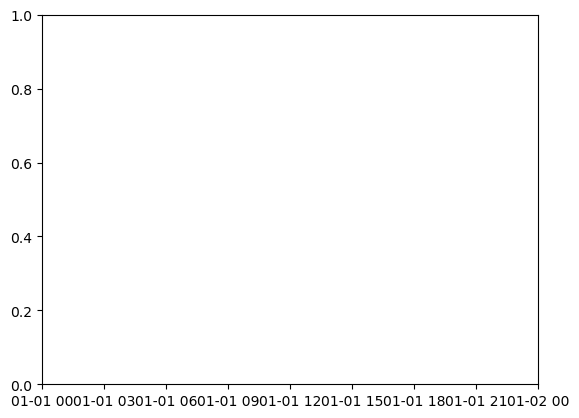

In [24]:
root_dir = '/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/illinois_qr/'

t2m_qr = xr.open_dataset(f'{root_dir}/95/t2m_overall_95qr.nc')
t2m_ds = daily_ds.t2m

time = daily_ds.date

plt.plot(time, t2m_ds)
